# Datasets


In [1]:
#| echo: false
#| label: 024_imports
import os
from math import inf
import matplotlib.pyplot as plt
import numpy as np
import warnings
if not os.path.exists('./figures'):
    os.makedirs('./figures')
warnings.filterwarnings("ignore")

## The Friedman Drift Dataset {#sec-a-05-friedman}

### The Friedman Drift Dataset as Implemented in `river`

We will describe the Friedman synthetic dataset with concept drifts [[SOURCE]](https://riverml.xyz/0.18.0/api/datasets/synth/FriedmanDrift/), see also @frie91a and @ikon11a.
Each observation is composed of ten features. Each feature value is sampled uniformly in [0, 1]. Only the first five features are relevant. The target is defined by different functions depending on the type of the drift. Global Recurring Abrupt drift will be used, i.e., the concept drift appears over the whole instance space.

The target is defined by the following function:
$$
y = 10 \sin(\pi x_0 x_1) + 20 (x_2 - 0.5)^2 + 10 x_3 + 5 x_4 + \epsilon,
$$
where $\epsilon \sim \mathcal{N}(0, 1)$ is normally distributed noise.

If the Global Recurring Abrupt drift variant of the Friedman Drift dataset is used, the target function changes at two points in time, namely $p_1$ and $p_2$.
At the first point, the concept changes to:
$$
y = 10 \sin(\pi x_3 x_5) + 20 (x_1 - 0.5)^2 + 10 x_0 + 5 x_2 + \epsilon,
$$
At the second point of drift the old concept reoccurs.
This can be implemented as follows, see [https://riverml.xyz/latest/api/datasets/synth/FriedmanDrift/](https://riverml.xyz/latest/api/datasets/synth/FriedmanDrift/):

```python
def __iter__(self):
    rng = random.Random(self.seed)

    i = 0
    while True:
        x = {i: rng.uniform(a=0, b=1) for i in range(10)}
        y = self._global_recurring_abrupt_gen(x, i) + rng.gauss(mu=0, sigma=1)

        yield x, y
        i += 1
```


```python
def _global_recurring_abrupt_gen(self, x, index: int):
    if index < self._change_point1 or index >= self._change_point2:
        # The initial concept is recurring
        return (
            10 * math.sin(math.pi * x[0] * x[1]) + 20 * (x[2] - 0.5) ** 2 + 10 * x[3] + 5 * x[4]
        )
    else:
        # Drift: the positions of the features are swapped
        return (
            10 * math.sin(math.pi * x[3] * x[5]) + 20 * (x[1] - 0.5) ** 2 + 10 * x[0] + 5 * x[2]
        )
```

`spotpython` requires the specification of a `train` and `test` data set. These data sets can be generated as follows:


In [2]:
#| label: a_05_friedman_data_set

from river.datasets import synth
import pandas as pd
import numpy as np
from spotRiver.utils.data_conversion import convert_to_df

seed = 123
shuffle = True
n_train = 6_000
n_test = 4_000
n_samples = n_train + n_test
target_column = "y"

dataset = synth.FriedmanDrift(
   drift_type='gra',
   position=(n_train/4, n_train/2),
   seed=123
)

train = convert_to_df(dataset, n_total=n_train)
train.columns = [f"x{i}" for i in range(1, 11)] + [target_column]


dataset = synth.FriedmanDrift(
   drift_type='gra',
   position=(n_test/4, n_test/2),
   seed=123
)
test = convert_to_df(dataset, n_total=n_test)
test.columns = [f"x{i}" for i in range(1, 11)] + [target_column]

In [3]:
def plot_data_with_drift_points(data, target_column, n_train, title=""):
    indices = range(len(data))
    y_values = data[target_column]

    plt.figure(figsize=(10, 6))
    plt.plot(indices, y_values, label="y Value", color='blue')

    drift_points = [n_train / 4, n_train / 2]
    for dp in drift_points:
        plt.axvline(x=dp, color='red', linestyle='--', label=f'Drift Point at {int(dp)}')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel('Index')
    plt.ylabel('Target Value (y)')
    plt.title(title)
    plt.grid(True)
    plt.show()

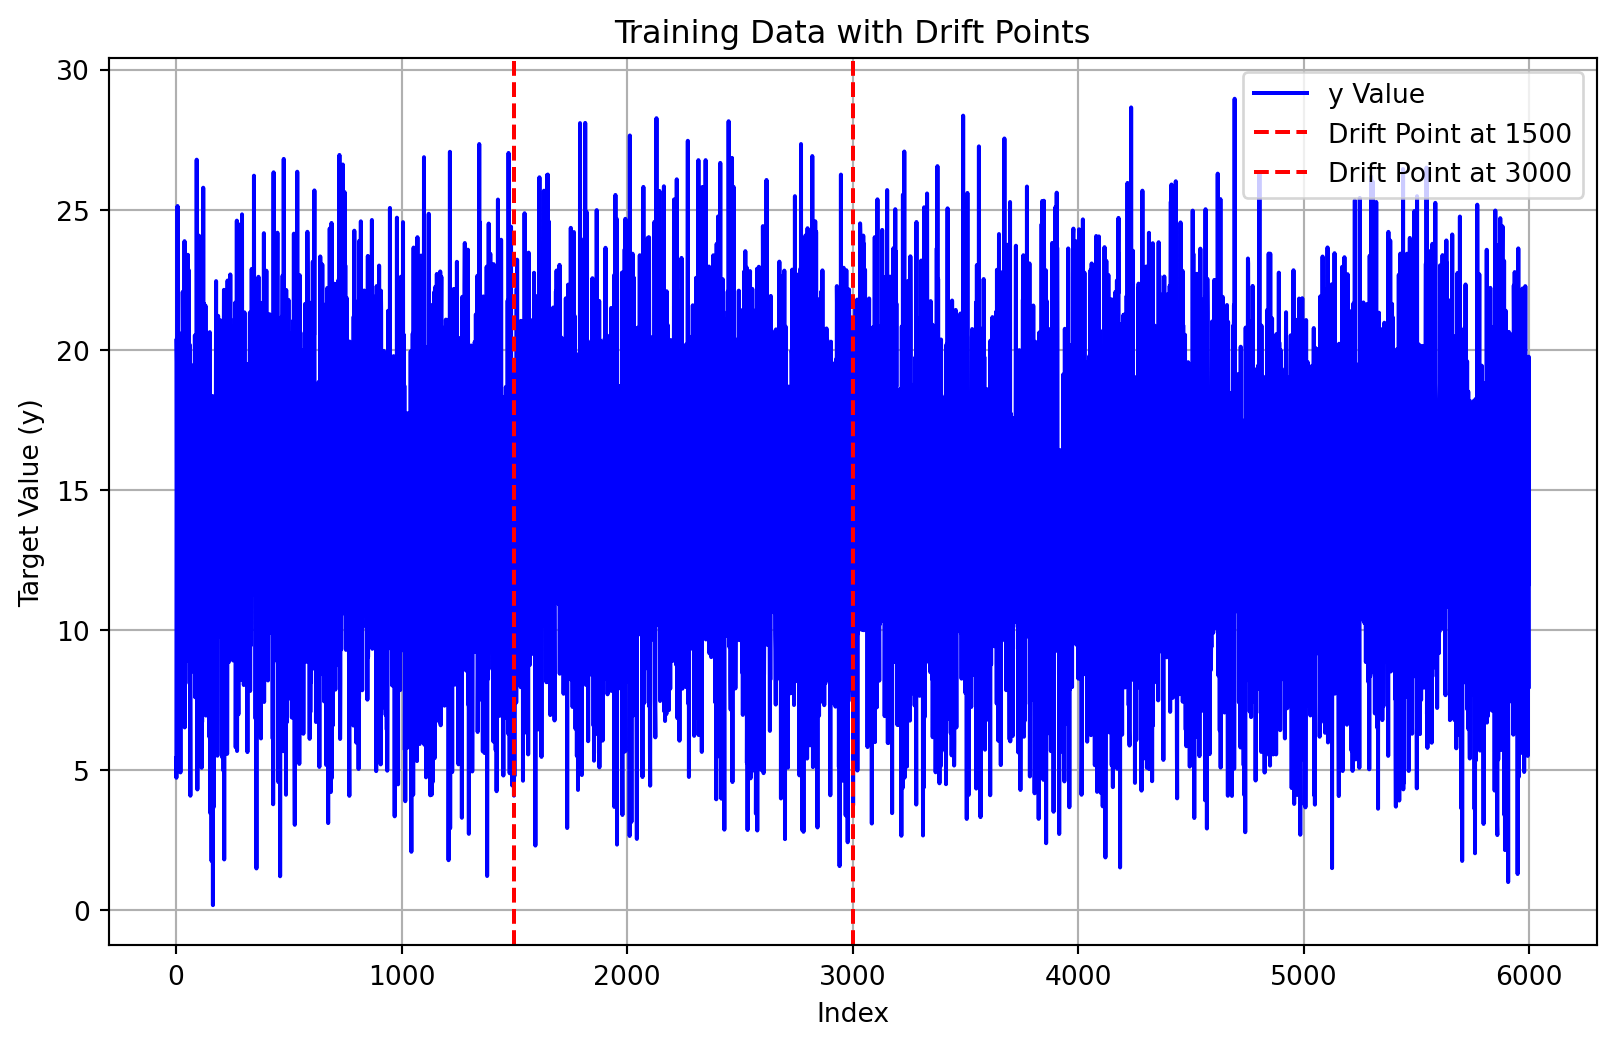

In [4]:
plot_data_with_drift_points(train, target_column, n_train, title="Training Data with Drift Points")

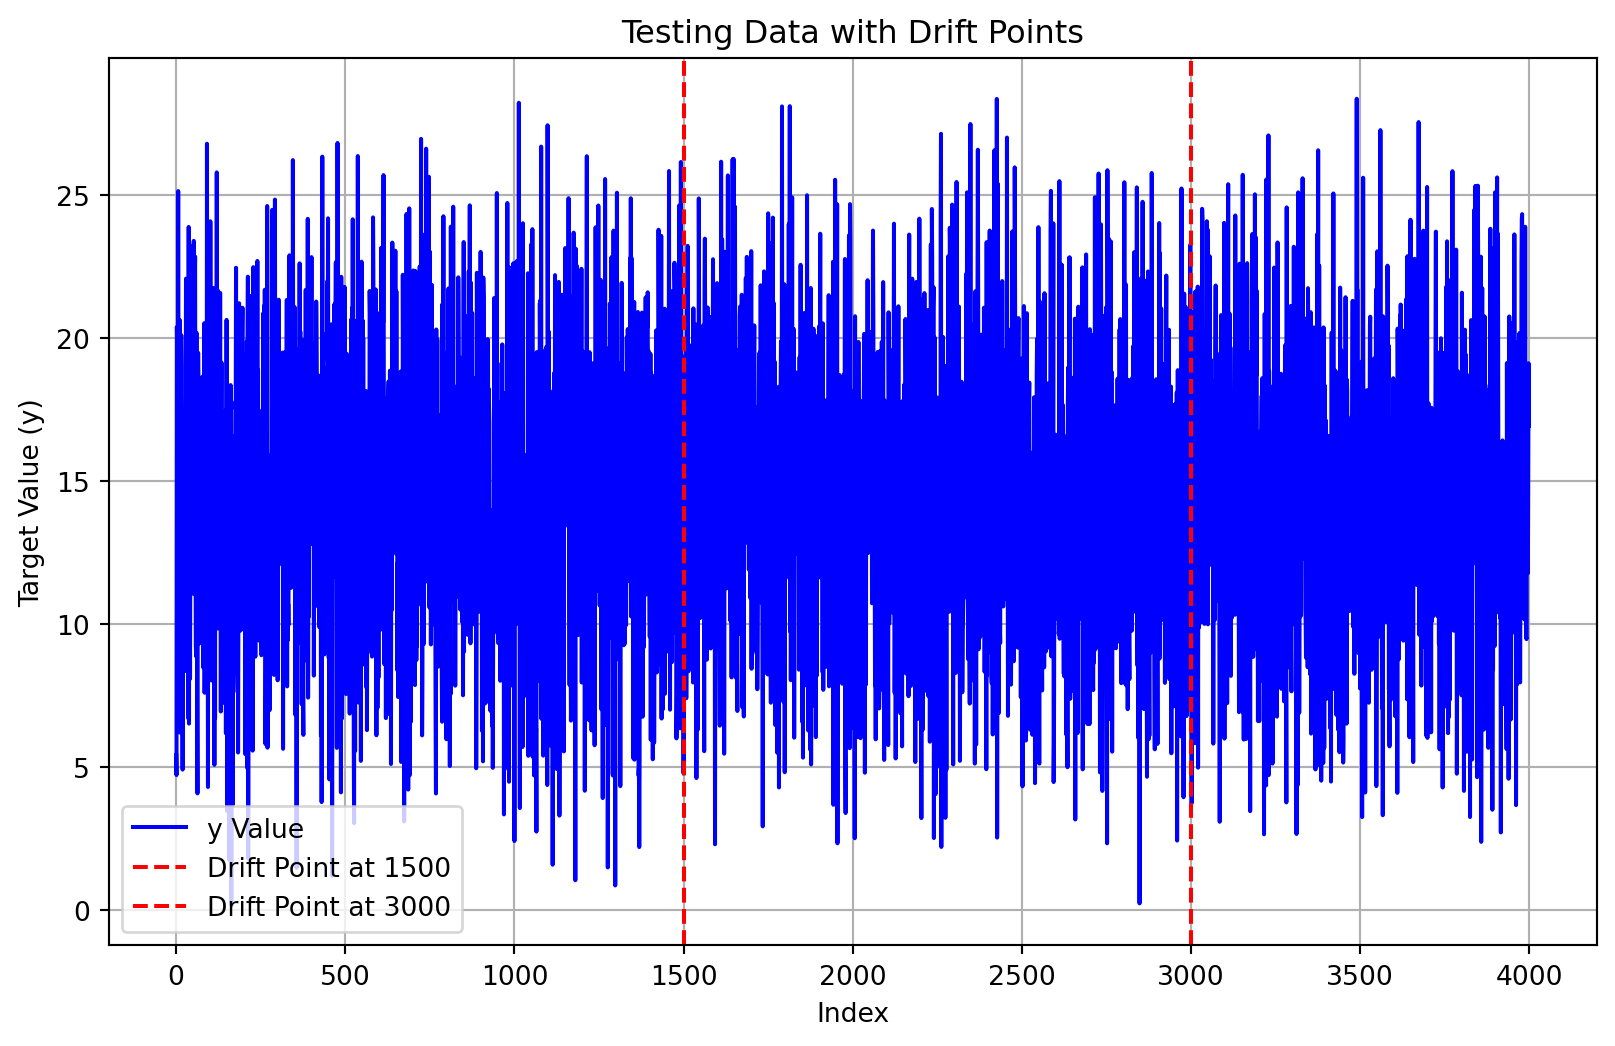

In [5]:
plot_data_with_drift_points(test, target_column, n_train, title="Testing Data with Drift Points")

### The Friedman Drift Data Set from `spotpython`

A data generator for the Friedman Drift dataset is implemented in the `spotPython` package, see [friedman.py](https://sequential-parameter-optimization.github.io/spotPython/reference/spotPython/data/friedman/). The `spotPython` version is a simplified version of the `river` implementation. The `spotPyton` version allows the generation of constant input values for the features. This is useful for visualizing the concept drifts. For the productive use the `river version` should be used.

Plotting the first 100 samples of the Friedman Drift dataset, we can not see the concept drifts at $p_1$ and $p_2$.
Drift can be visualized by plotting the target values over time for constant features, e,g, if $x_0$ is set to $1$ and all other features are set to $0$. This is illustrated in the following plot.


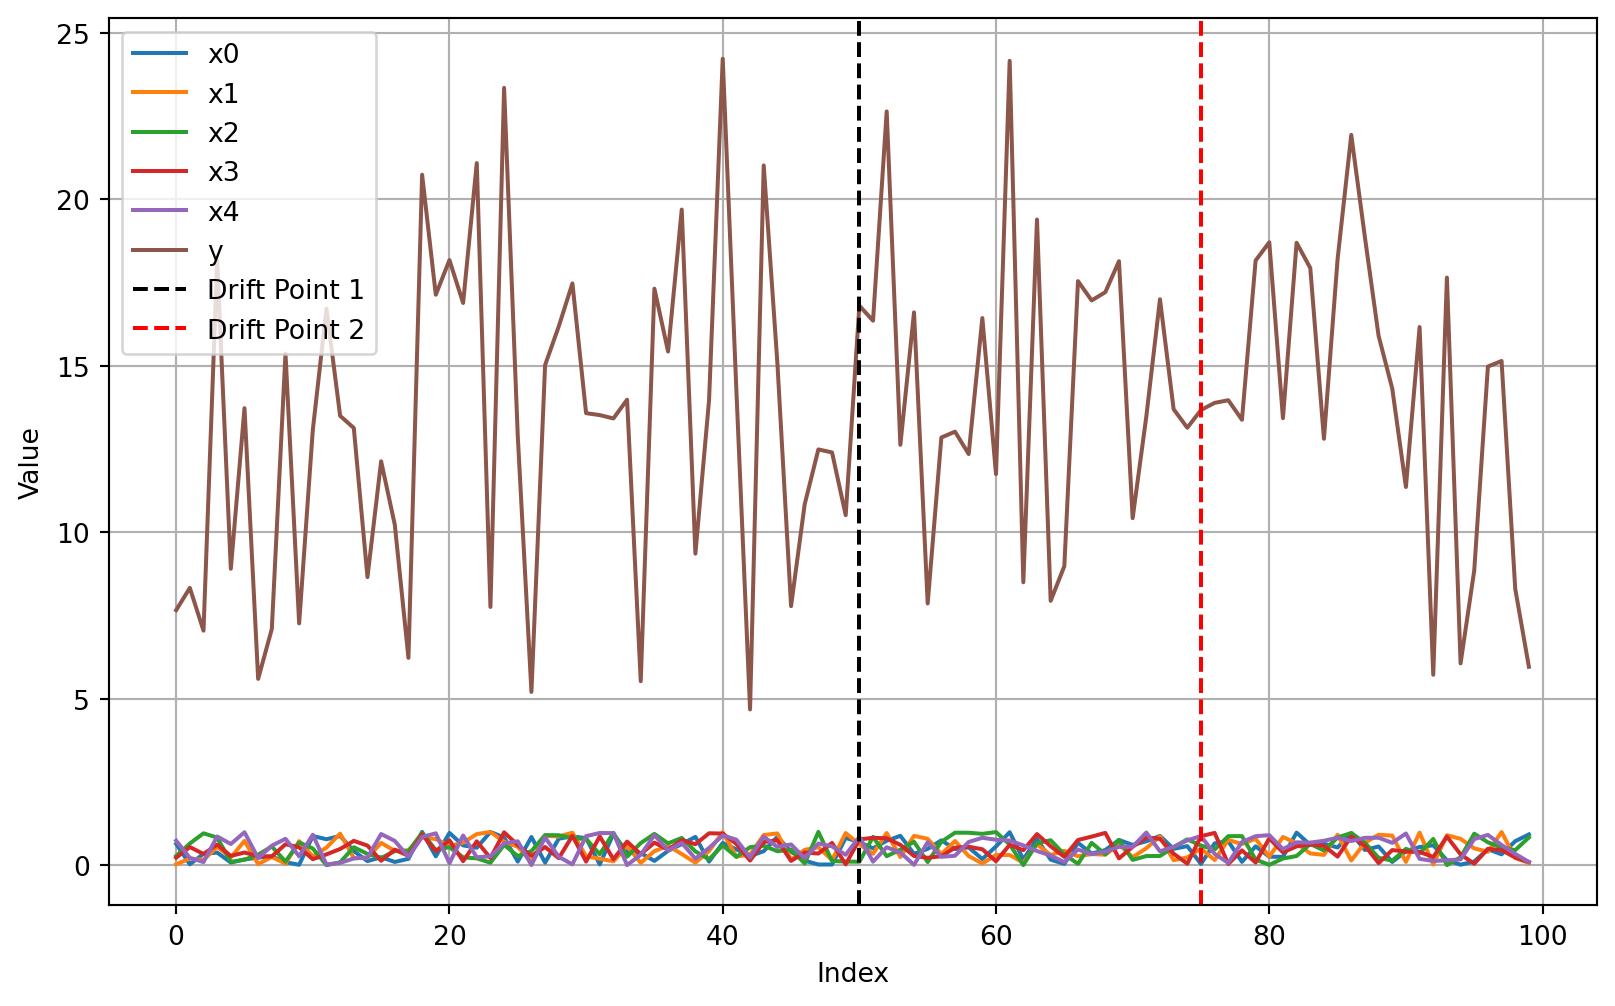

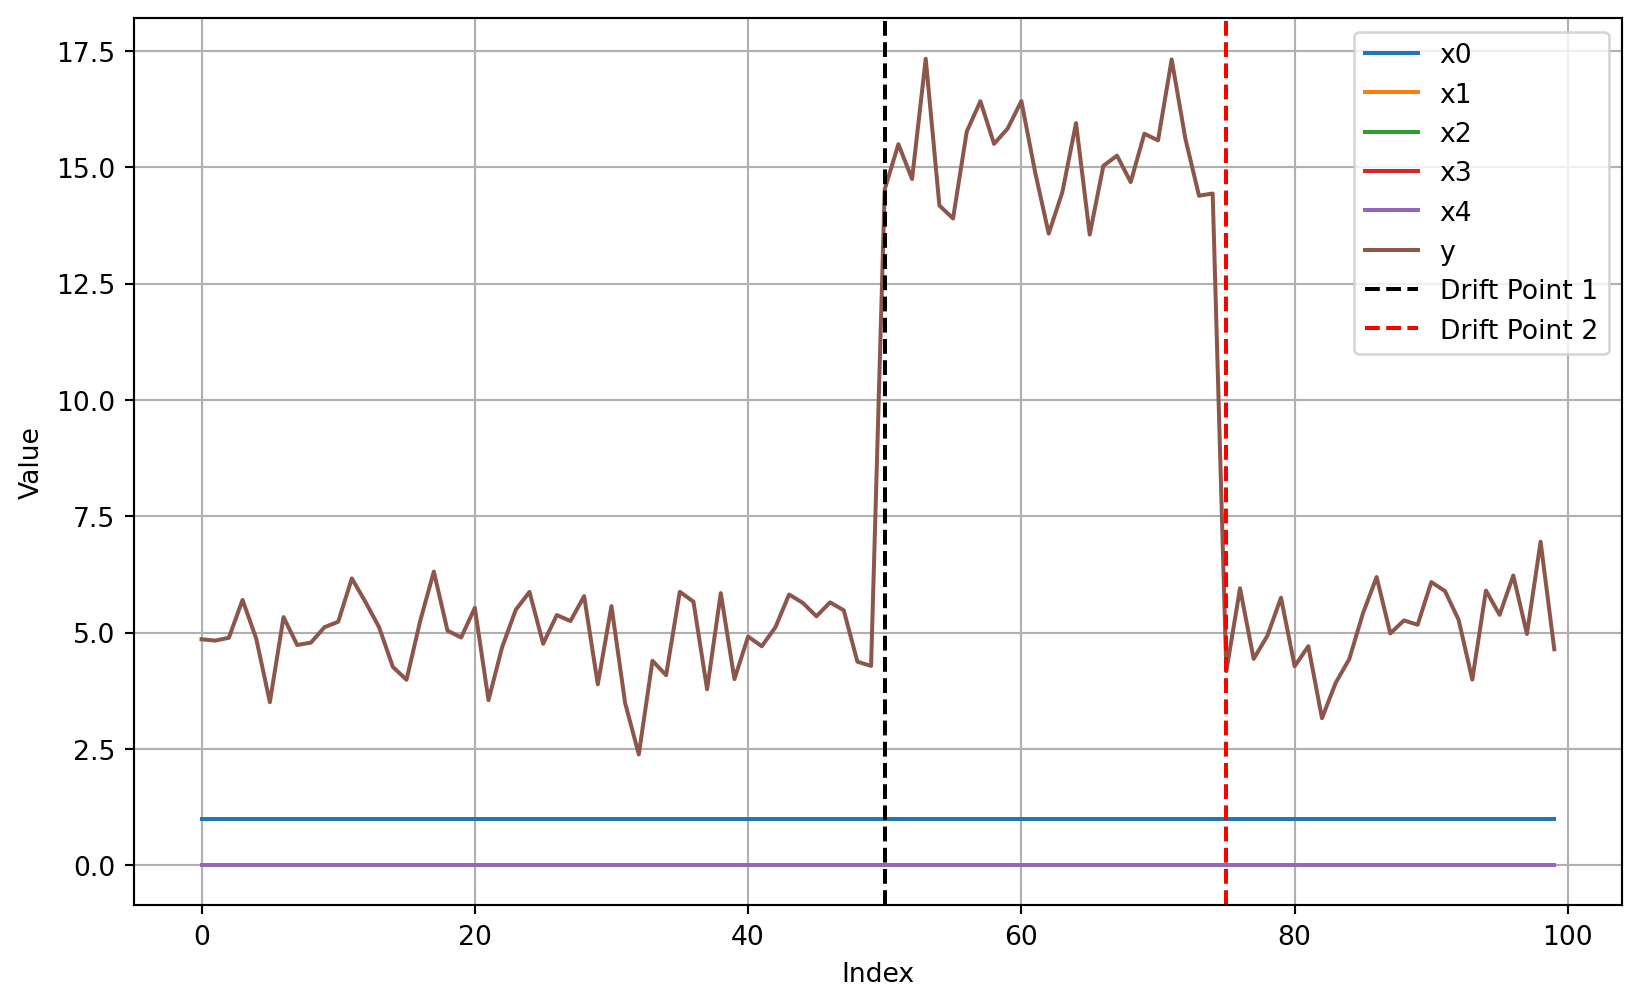

In [6]:
from spotPython.data.friedman import FriedmanDriftDataset

def plot_friedman_drift_data(n_samples, seed, change_point1, change_point2, constant=True):
    data_generator = FriedmanDriftDataset(n_samples=n_samples, seed=seed, change_point1=change_point1, change_point2=change_point2, constant=constant)
    data = [data for data in data_generator]
    indices = [i for _, _, i in data]
    values = {f"x{i}": [] for i in range(5)}
    values["y"] = []
    for x, y, _ in data:
        for i in range(5):
            values[f"x{i}"].append(x[i])
        values["y"].append(y)

    plt.figure(figsize=(10, 6))
    for label, series in values.items():
        plt.plot(indices, series, label=label)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.axvline(x=change_point1, color='k', linestyle='--', label='Drift Point 1')
    plt.axvline(x=change_point2, color='r', linestyle='--', label='Drift Point 2')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_friedman_drift_data(n_samples=100, seed=42, change_point1=50, change_point2=75, constant=False)
plot_friedman_drift_data(n_samples=100, seed=42, change_point1=50, change_point2=75, constant=True)